In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.7.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla K80


### Data preprocessing and cleaning:

In [4]:
# input image dimensions
img_rows, img_cols = 32, 32

In [5]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [7]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 200

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks work best when each input is inside the range –1 to 1, so we need to divide by 255.

In [10]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [11]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [12]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(128)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

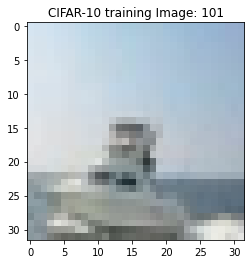

In [13]:
# Visualize CIFAR-10 dataset-
img_idx = 100

plt.imshow(X_train[img_idx])
plt.title(f"CIFAR-10 training Image: {img_idx + 1}")
plt.show()

### Define _Variational Autoencoder_ architecture

In [14]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        return x
    

In [15]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
    
    def call(self, X):
        X = self.conv_block1(X)
        # print(f"conv_block1.shape: {X.shape}")
        # conv_block1.shape: (batch_size, 14, 14, 64)
        X = self.conv_block2(X)
        # print(f"conv_block2.shape: {X.shape}")
        # conv_block2.shape: (batch_size, 5, 5, 128)
        X = self.conv_block3(X)
        # print(f"conv_block3.shape: {X.shape}")
        # conv_block3.shape: (batch_size, 2, 2, 256)
        X = self.flatten(X)
        # print(f"X.flatten: {X.shape}")
        # X.flatten: (batch_size, 1024)
        X = tf.keras.activations.relu(self.bn(self.output_layer(X)))
        return X
    

In [16]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
        '''
        # self.inp_layer = InputLayer(input_shape = self.latent_dim)
        
        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        '''
        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense_layer = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn1 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((4, 4, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer2 = Conv2D(
            filters = 256, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer4 = Conv2D(
            filters = 128, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same'
            )
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        """
        self.conv_layer6 = Conv2D(
            filters = 64, kernel_size = (3, 3),
            strides = (1, 1), padding = 'same'
        )
        """
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same'
            )
        
    
    def call(self, X):
        # X = self.inp_layer(X)
        # X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn1(self.dense_layer(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn2(self.conv_transpose_layer1(X)))
        # X = tf.keras.activations.relu(self.bn3(self.conv_layer2(X)))
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer3(X)))
        # X = tf.keras.activations.relu(self.bn5(self.conv_layer4(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.relu(self.bn7(self.conv_layer6(X)))
        X = tf.keras.activations.sigmoid(self.final_conv_layer(X))

        return X
        

In [ ]:
# encoder = Conv6_Encoder(latent_dim = 100)

In [ ]:
# X = X_train[:3, :]

In [ ]:
# X_encoded = encoder(X)

In [ ]:
# X_encoded.shape
# TensorShape([3, 100])

In [ ]:
# decoder = Conv6_Decoder(latent_dim = 100)

In [ ]:
# X_recon = decoder(X_encoded)

In [ ]:
# X_recon.shape, X.shape
# (TensorShape([3, 32, 32, 3]), (3, 32, 32, 3))

In [ ]:
# del X, X_recon, X_encoded, encoder, decoder

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (z_mean, z_log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var)
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate Gaussian
        # normal distribution-
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))

        return mu + tf.exp(0.5 * log_var) * epsilon


In [17]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mean, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(shape = mean.shape)
        return (eps * tf.exp(logvar * 0.5) + mean)
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        # z = Sampling()(mu, log_var)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''
        
        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var
        

In [38]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [19]:
# Sanity check-
X = X_train[:4, :]

In [20]:
# Forward pass using input data-
X_recon, mu, log_var = model(X)

In [21]:
X.shape, X_recon.shape

((4, 32, 32, 3), TensorShape([4, 32, 32, 3]))

In [22]:
mu.shape, log_var.shape

(TensorShape([4, 100]), TensorShape([4, 100]))

In [23]:
mu.numpy().mean(), mu.numpy().std()

(-0.00076435134, 0.014420886)

In [24]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.00076000864, 0.013629697)

In [25]:
del X, X_recon, mu, log_var

In [26]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv6__encoder (Conv6_Encod  multiple                 1250996   
 er)                                                             
                                                                 
 conv6__decoder (Conv6_Decod  multiple                 6061123   
 er)                                                             
                                                                 
 dense_3 (Dense)             multiple                  10100     
                                                                 
 dense_4 (Dense)             multiple                  10100     
                                                                 
Total params: 7,332,319
Trainable params: 7,318,295
Non-trainable params: 14,024
_________________________________________________________________


In [27]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294912 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589823 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,) has 1024 parameters
layer: (1024,) has 0 parameters
layer: (1024, 4096) has 4194304 parameters
layer: (4096,) has 0 parameters
layer

In [28]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 7304963 trainable parameters


In [39]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

### Train model with _tf.GradientTape()_ and _Early Stopping_ criterion

In [40]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [ ]:
'''
total_loss, recon_loss, kl_loss = compute_loss(
    data = X, reconstruction = X_recon,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23451519>

In [41]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        X_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = X_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads), len(grads)
    # (list, 20)
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [42]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    X_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = X_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
total_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = X, alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23313756>

In [43]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [44]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [35]:
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 10000
# loc_patience = 0

In [36]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [45]:
for epoch in range(1, 31):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

    """
    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        model.save_weights("VAE_CIFAR10_best_model.h5", overwrite = True)
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    """



epoch = 1; total train loss = 260107.3600, train recon loss = 26009.8213, train kl loss = 9.1467; total val loss = 51458.9727, val recon loss = 5145.3168 & val kl loss = 5.8043
epoch = 2; total train loss = 233042.1688, train recon loss = 23126.5660, train kl loss = 1776.5084; total val loss = 44602.6396, val recon loss = 4414.6187 & val kl loss = 456.4526
epoch = 3; total train loss = 215867.3778, train recon loss = 21238.2451, train kl loss = 3484.9264; total val loss = 42159.0859, val recon loss = 4127.4857 & val kl loss = 884.2292
epoch = 4; total train loss = 209668.2307, train recon loss = 20499.9399, train kl loss = 4668.8322; total val loss = 41441.6537, val recon loss = 4036.3567 & val kl loss = 1078.0870
epoch = 5; total train loss = 205744.9301, train recon loss = 20028.2247, train kl loss = 5462.6828; total val loss = 40720.9479, val recon loss = 3957.8263 & val kl loss = 1142.6853
epoch = 6; total train loss = 203007.4460, train recon loss = 19741.3002, train kl loss = 559

In [46]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [47]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [48]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [49]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [50]:
# Save trained model-
model.save_weights("VAE_CIFAR10_trained.h5", overwrite = True)

In [ ]:
'''
import pickle

# Save training history as pickle file-
with open("VAE_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)
'''

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_CIFAR10_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Visualize training metrics

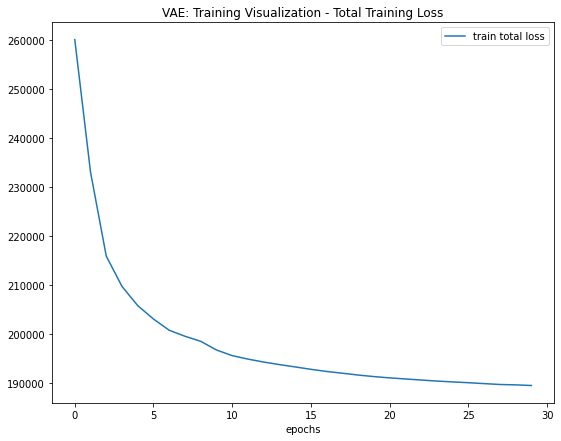

In [51]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

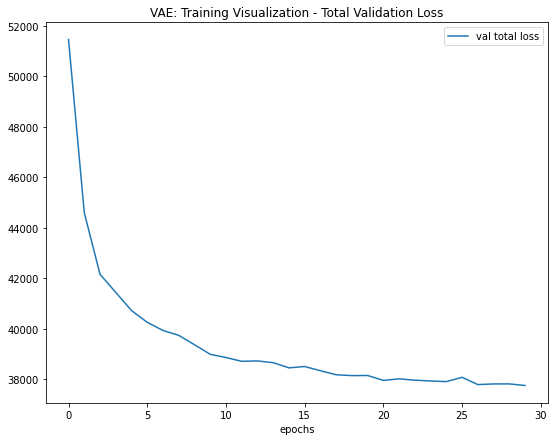

In [52]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

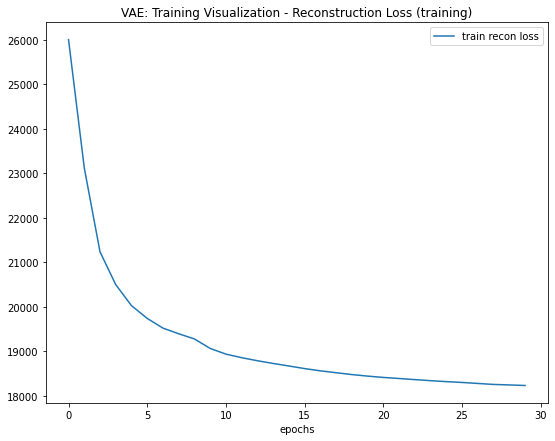

In [53]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

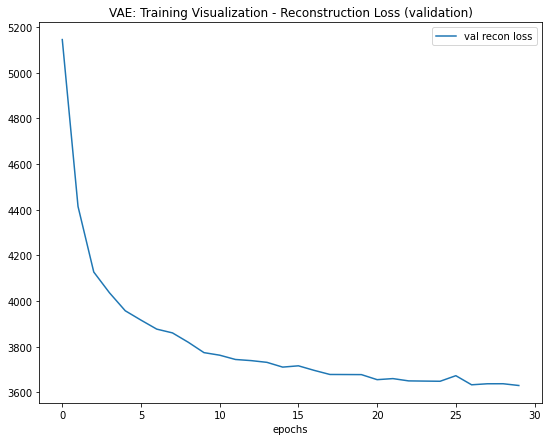

In [54]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

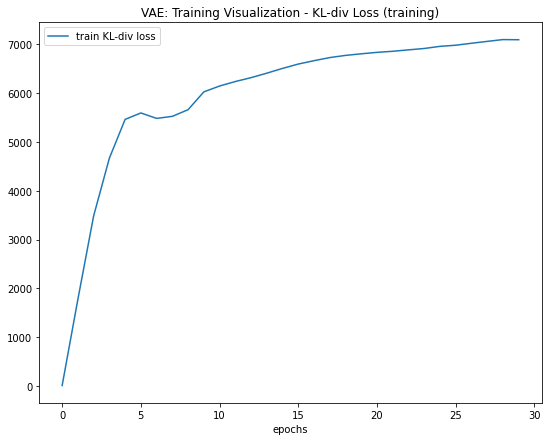

In [55]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

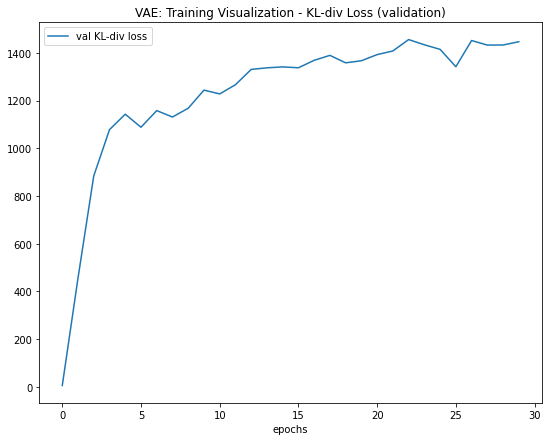

In [56]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [57]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:5000, :])

In [58]:
# Sanity check-
X_train[:5000, :].shape, X_train_reconstruced.shape

((5000, 32, 32, 3), TensorShape([5000, 32, 32, 3]))

In [ ]:
'''
X_train_reconstruced = tf.reshape(
    tensor = X_train_reconstruced,
    shape = ((X_train_reconstruced.shape[0], X_train_reconstruced.shape[1], X_train_reconstruced.shape[2] )),
    name = None
    )
'''

In [59]:
# Sanity check-
X_train_reconstruced.numpy().shape

(5000, 32, 32, 3)

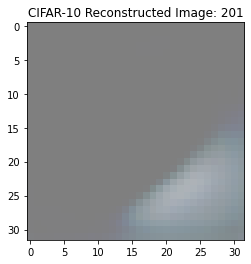

In [60]:
# Visualize reconstructed CIFAR-10 image-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

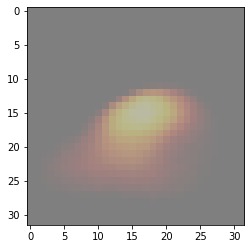

In [61]:
# Visualize a single image-
plt.imshow(X_train_reconstruced[0])
plt.show()

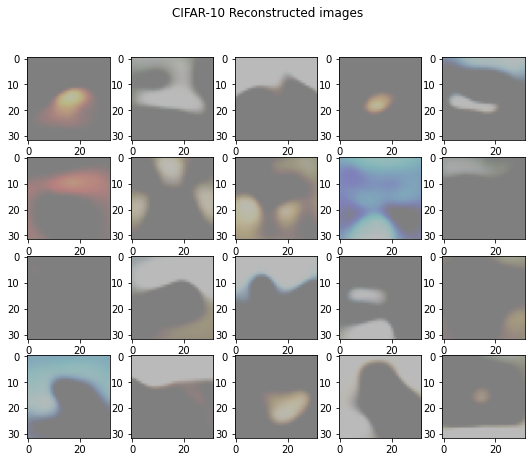

In [63]:
# Visualize 10 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [64]:
mu.shape, log_var.shape

(TensorShape([5000, 100]), TensorShape([5000, 100]))

In [65]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = 0.0016 & std dev = 0.4039


In [66]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -0.368417 & std dev = 0.8810


((50000, 1), (10000, 1))

In [70]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [72]:
y_train.shape, y_test.shape

((50000,), (10000,))

### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

In [74]:
# Visualize  latent space mean-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train[:5000]
    )
fig.show()

In [75]:
# Visualize  latent space log variance-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train[:5000]
    )
fig.show()

### Visualize _latent space_ of train & test datasets

In [ ]:
X_train_encoded = model.encoder(X_train)
X_test_encoded = model.encoder(X_test)

In [ ]:
X_train.shape, X_train_encoded.shape

In [ ]:
X_test.shape, X_test_encoded.shape

In [ ]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    # color = y_train
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    color = y_test
)
fig.show()

In [ ]:
del X_train_encoded, X_test_encoded